<a href="https://colab.research.google.com/github/Elman295/Face_recognition_AT-T/blob/main/Face_recognition_AT%26T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision 
from torchvision import datasets
from torchvision import models 
from torchvision import transforms 
from torch import nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
import random

In [2]:
with zipfile.ZipFile("att_faces.zip","r") as f:
  f.extractall("data")

In [3]:
training_ds = datasets.ImageFolder(
    
    root = "data/att_faces"
)
training_ds.class_to_idx

{'s1': 0,
 's10': 1,
 's11': 2,
 's12': 3,
 's13': 4,
 's14': 5,
 's15': 6,
 's16': 7,
 's17': 8,
 's18': 9,
 's19': 10,
 's2': 11,
 's20': 12,
 's21': 13,
 's22': 14,
 's23': 15,
 's24': 16,
 's25': 17,
 's26': 18,
 's27': 19,
 's28': 20,
 's29': 21,
 's3': 22,
 's30': 23,
 's31': 24,
 's32': 25,
 's33': 26,
 's34': 27,
 's35': 28,
 's36': 29,
 's37': 30,
 's38': 31,
 's39': 32,
 's4': 33,
 's40': 34,
 's5': 35,
 's6': 36,
 's7': 37,
 's8': 38,
 's9': 39}

In [4]:
class TripleDataSet(Dataset):

  def __init__(self, images, transform = None):
    self.images = images
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,id):
    
    anchor, anchor_label = self.images[id] 

    pos = random.choice([img for img,lbl in self.images if lbl == anchor_label])
    neg = random.choice([img for img,lbl in self.images if lbl != anchor_label])

    anchor = Image.open(anchor).convert("RGB")
    pos = Image.open(pos).convert("RGB")
    neg = Image.open(neg).convert("RGB")

    anchor = self.transform(anchor)
    pos = self.transform(pos)
    neg = self.transform(neg) 

    return anchor, pos, neg 




In [5]:
tfms = transforms.Compose([
    
    transforms.Resize(size = (90,90)),
    transforms.RandomCrop(size = 90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()


])

train_ds = TripleDataSet(images=training_ds.imgs, transform = tfms)
train_dataloader = DataLoader(train_ds, batch_size = 16, shuffle =False, num_workers=0) 

In [6]:
train_dataloader.dataset

In [7]:
def show_image(image, text):
  image = image.numpy().transpose((1,2,0))
  plt.text(175,10,text)
  plt.imshow(image)
  plt.show()

def get_model(model, pretrained = True):
  return models.__dict__[model](pretrained)

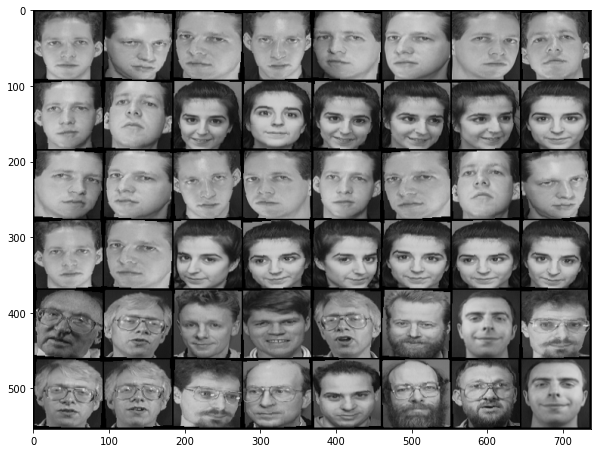

In [8]:
plt.figure(figsize = (10,10))
anchors, pos, neg = next(iter(train_dataloader)) 
out = torch.cat(tensors = (anchors,pos,neg),dim = 0) 
image = torchvision.utils.make_grid(out) 
plt.imshow(np.transpose(image,(1,2,0)))
plt.show()

In [9]:
if torch.cuda.is_available():
  device =torch.device("cuda") 
else:
  device = torch.device("cpu")

In [10]:
class TripleModel(nn.Module):

  def __init__(self,model):
    super(TripleModel, self).__init__() 
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512,128)
    )
    self.model = model

  def forward(self, anchor, pos, neg):
    f_anchor =  self.model(anchor)
    f_pos = self.model(pos)
    f_neg = self.model(neg)
    return f_anchor, f_pos, f_neg

In [11]:
model = get_model("resnet50")
model_t = TripleModel(model) 
model_t.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

TripleModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [12]:
class TripleLoss(nn.Module):

  def __init__(self,margin = 0.2):
    super(TripleLoss,self).__init__()
    self.margin =margin

  def forward(self,f_anchor,f_pos,f_neg):
    distance_pos = F.pairwise_distance(f_anchor, f_pos)
    distance_neg = F.pairwise_distance(f_anchor, f_neg) 
    loss =  torch.sum(torch.clamp(torch.pow(distance_pos,2) - torch.pow(distance_neg,2) + self.margin,min = 0)) 
    return loss

In [13]:
loss_fn = TripleLoss()
loss_fn.to(device)

TripleLoss()

In [14]:
optim = torch.optim.Adam(model_t.parameters(), lr = 0.0002)

In [15]:
def train(dataloader, model, loss_function,optim):
  for batch, (anchor, pos, neg) in enumerate(dataloader):
    anchor, pos, neg = anchor.to(device),pos.to(device),neg.to(device) 
    f_anchor, f_pos, f_neg = model(anchor, pos,neg) 
    loss = loss_function(f_anchor, f_pos, f_neg) 
    optim.zero_grad() 
    loss.backward() 
    optim.step()
    if batch % 100 == 0:
      loss = loss.item()
      print(f"loss is {loss} =============")

In [19]:
training_dataloader = DataLoader(training_ds,batch_size = 16, shuffle = True)

In [20]:
EPOCHS = 20
for epoch in range(EPOCHS):
  print(f"epoch: {epoch+1}=-=-=-=-=-=-=-=-=-=-=-=-")
  train(train_dataloader, model_t,loss_fn,optim) 
print("DONE !!!")

epoch: 1=-=-=-=-=-=-=-=-=-=-=-=-
loss is 5.036803245544434 =============
epoch: 2=-=-=-=-=-=-=-=-=-=-=-=-
loss is 18.45481300354004 =============
epoch: 3=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 4=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 5=-=-=-=-=-=-=-=-=-=-=-=-
loss is 1.081074595451355 =============
epoch: 6=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 7=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 8=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 9=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.8181883692741394 =============
epoch: 10=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 11=-=-=-=-=-=-=-=-=-=-=-=-
loss is 1.9268691539764404 =============
epoch: 12=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 13=-=-=-=-=-=-=-=-=-=-=-=-
loss is 6.26069450378418 =============
epoch: 14=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 15=-=-=-=-=-=-=-=-=-=-=-=-
loss is 0.0 =============
epoch: 16=-=-=-=-=-=-=-=

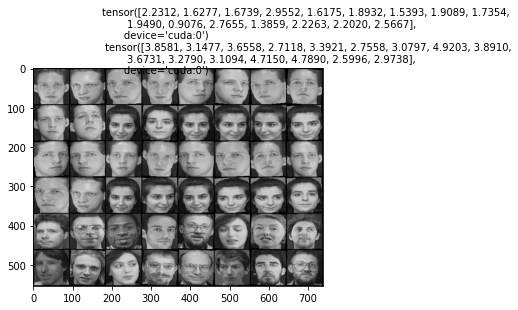

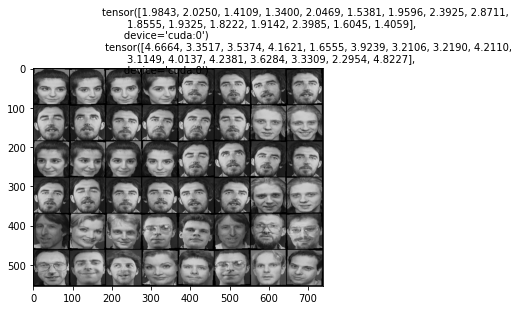

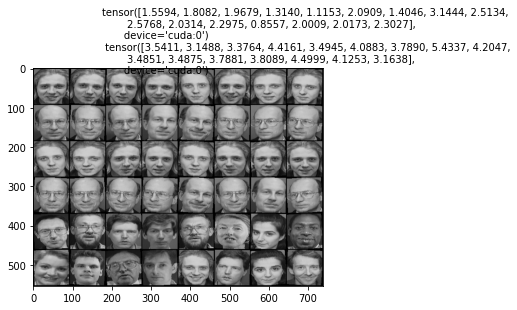

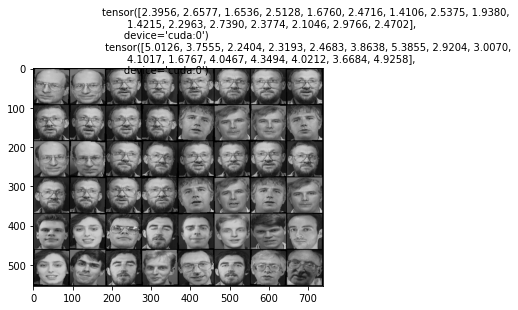

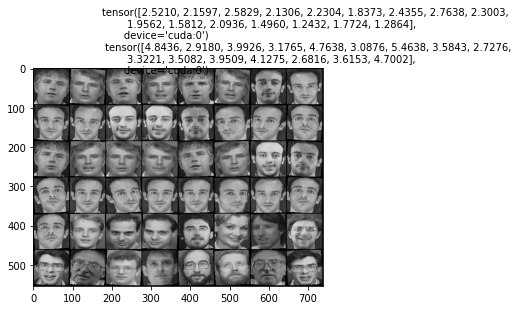

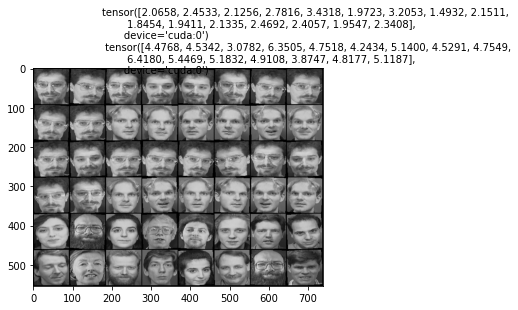

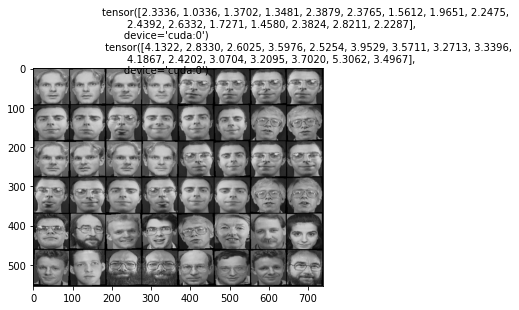

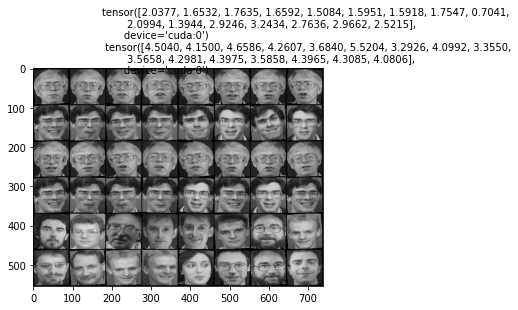

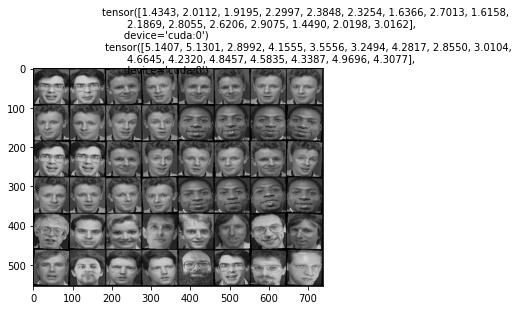

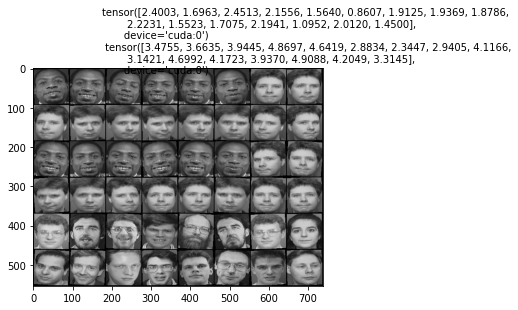

In [21]:
dataiter = iter(train_dataloader)

with torch.no_grad():
  for i in range(10):
    x0,x1,x2 = next(dataiter)
    out = torch.cat(tensors = (x0,x1,x2),dim = 0)
    f0,f1,f2 = model_t(x0.to(device), x1.to(device), x2.to(device))
    pos_dis = F.pairwise_distance(f0,f1)
    neg_dis =F.pairwise_distance(f0,f2) 
    show_image(torchvision.utils.make_grid(out),text = f"{pos_dis} \n {neg_dis}")